In [1]:
# import libraries
from cil.optimisation.algorithms import CGLS, FISTA
from cil.optimisation.functions import OperatorCompositionFunction, L2NormSquared
from cil.optimisation.operators import BlockOperator, IdentityOperator
from cil.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.utilities.display import show2D

import numpy as np
import os, sys

import tomophantom
from tomophantom import TomoP2D

In [2]:
# Load a tomophantom image 
model = 1 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D_np = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N, voxel_size_x = 0.1, voxel_size_y = 0.1)

phantom2D = ig.allocate()
phantom2D.fill(phantom2D_np)

In [3]:
# Create Acquisition Geometry
detectors =  int(np.sqrt(2)*N)
angles = np.linspace(0, np.pi, 180, dtype=np.float32)

ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles,angle_unit="radian")\
                        .set_panel(detectors, pixel_size=0.1)

In [4]:
device = "gpu"

In [5]:
# Create Projection Operator
A = ProjectionOperator(ig, ag, device )

In [6]:
# Create projection data and corrupt with noise
np.random.seed(10)

data = A.direct(phantom2D)
noisy_data = ag.allocate()
noisy_data.fill(data.as_array() + np.random.normal(0, 0.5, ag.shape))

In [7]:
# FBP reconstruction
fbp = FBP(ig, ag)(noisy_data)

In [8]:
alpha = 5

In [9]:
# Setup and run FISTA
f = OperatorCompositionFunction(L2NormSquared(b=noisy_data),A)
g = alpha * L2NormSquared()
fista = FISTA(initial=ig.allocate(), f=f, g=g, max_iteration=200, update_objective_interval=50)
fista.run(verbose=1)

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          6.14495e+05
       50        200         0.027          2.92816e+04
      100        200         0.028          2.92833e+04
      150        200         0.027          2.92852e+04
      200        200         0.027          2.92860e+04
-------------------------------------------------------
      200        200         0.027          2.92860e+04
Stop criterion has been reached.



In [10]:
# Setup and run Regularised CGLS reconstruction, Tikhonov regularisation
block_operator = BlockOperator( A, np.sqrt(alpha) * IdentityOperator(ig), shape=(2,1))
block_data = BlockDataContainer(noisy_data, ig.allocate())

cgls_reg = CGLS(initial=ig.allocate(), operator = block_operator, data = block_data, 
            max_iteration=100, update_objective_interval=10)
cgls_reg.run(100, verbose=1)

CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          6.14495e+05
       10        100         0.047          2.94024e+04
       20        100         0.048          2.92870e+04
       30        100         0.049          2.92863e+04
       38        100         0.049                     
Tolerance is reached: 1e-06
-------------------------------------------------------
       38        100         0.049                     
Stop criterion has been reached.



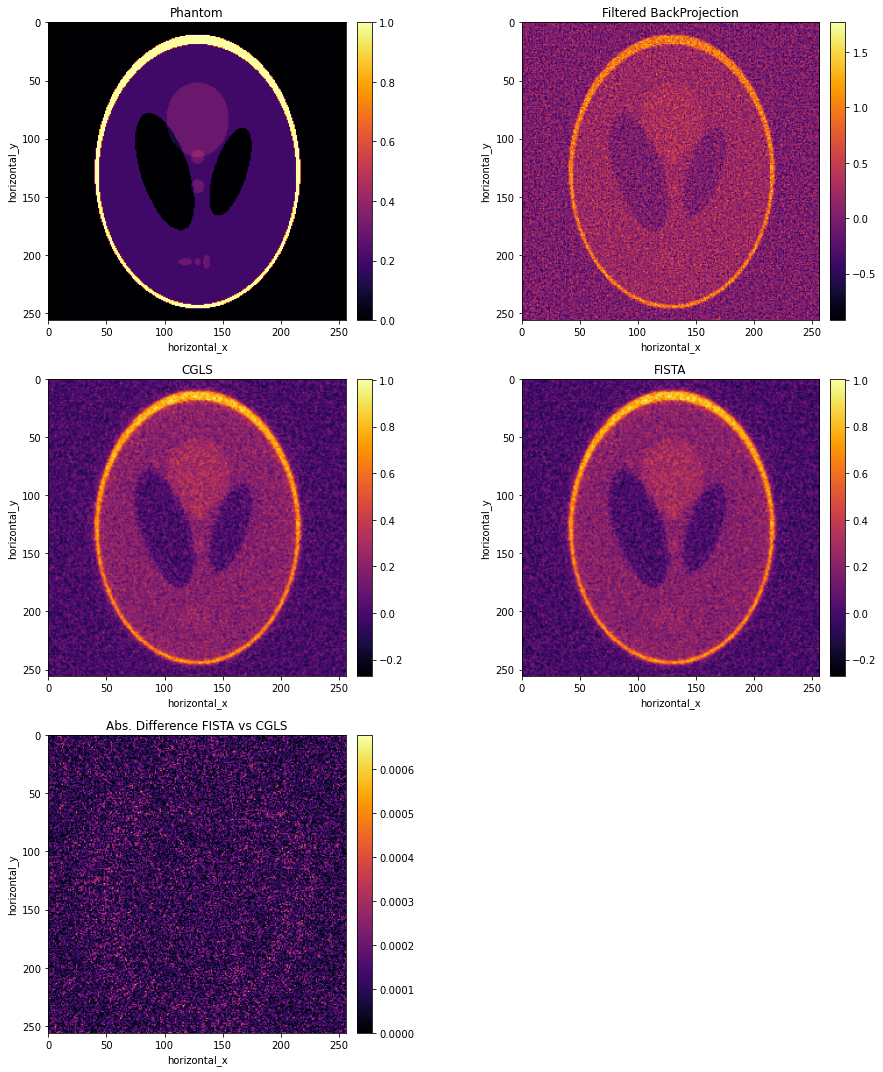

In [12]:
show2D([phantom2D, fbp, cgls_reg.solution, fista.solution, (cgls_reg.solution-fista.solution).abs()],
          title=["Phantom", "Filtered BackProjection", "CGLS", "FISTA", "Abs. Difference FISTA vs CGLS"],
         origin = "upper", cmap="inferno")